In [235]:
#pip install opencv-python opencv-contrib-python matplotlib numpy

In [236]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

The first step is to find the correspondences between the image book (Figure 2.a) and the
first frame of the video.

In [237]:
# Load the book image
img_book = cv2.imread("cv_cover.jpg")  
img_book = cv2.cvtColor(img_book, cv2.COLOR_BGR2RGB)
# Load the first frame from the video
cap = cv2.VideoCapture("book.mov")  
ret, frame_video = cap.read()
cap.release()
if not ret:
    raise ValueError("Failed to read the first video frame.")
frame_video_rgb = cv2.cvtColor(frame_video, cv2.COLOR_BGR2RGB)
# Convert images to grayscale
gray_book = cv2.cvtColor(img_book, cv2.COLOR_RGB2GRAY)
gray_video = cv2.cvtColor(frame_video_rgb, cv2.COLOR_RGB2GRAY)
#Now we have 

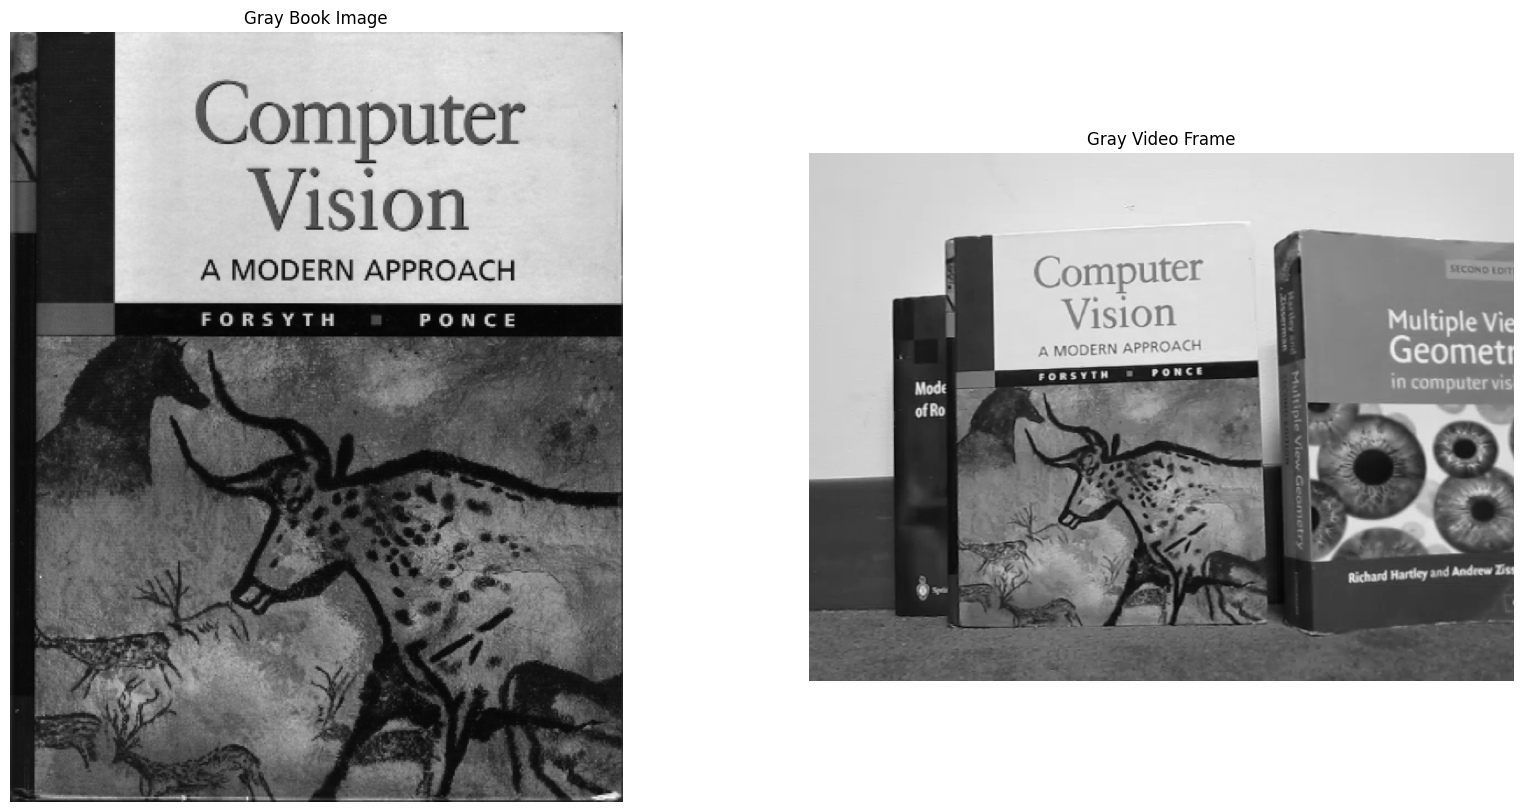

In [238]:
plt.figure(figsize=(20, 10))  # Set overall figure size
# Plot first image (gray_book)
plt.subplot(1, 2, 1)  # (rows, columns, image_index)
plt.imshow(gray_book,"gray")
plt.axis('off')
plt.title('Gray Book Image')
# Plot second image (gray_video)
plt.subplot(1, 2, 2)
plt.imshow(gray_video,"gray")
plt.axis('off')
plt.title('Gray Video Frame')
plt.show()


1.1) Getting Correspondences

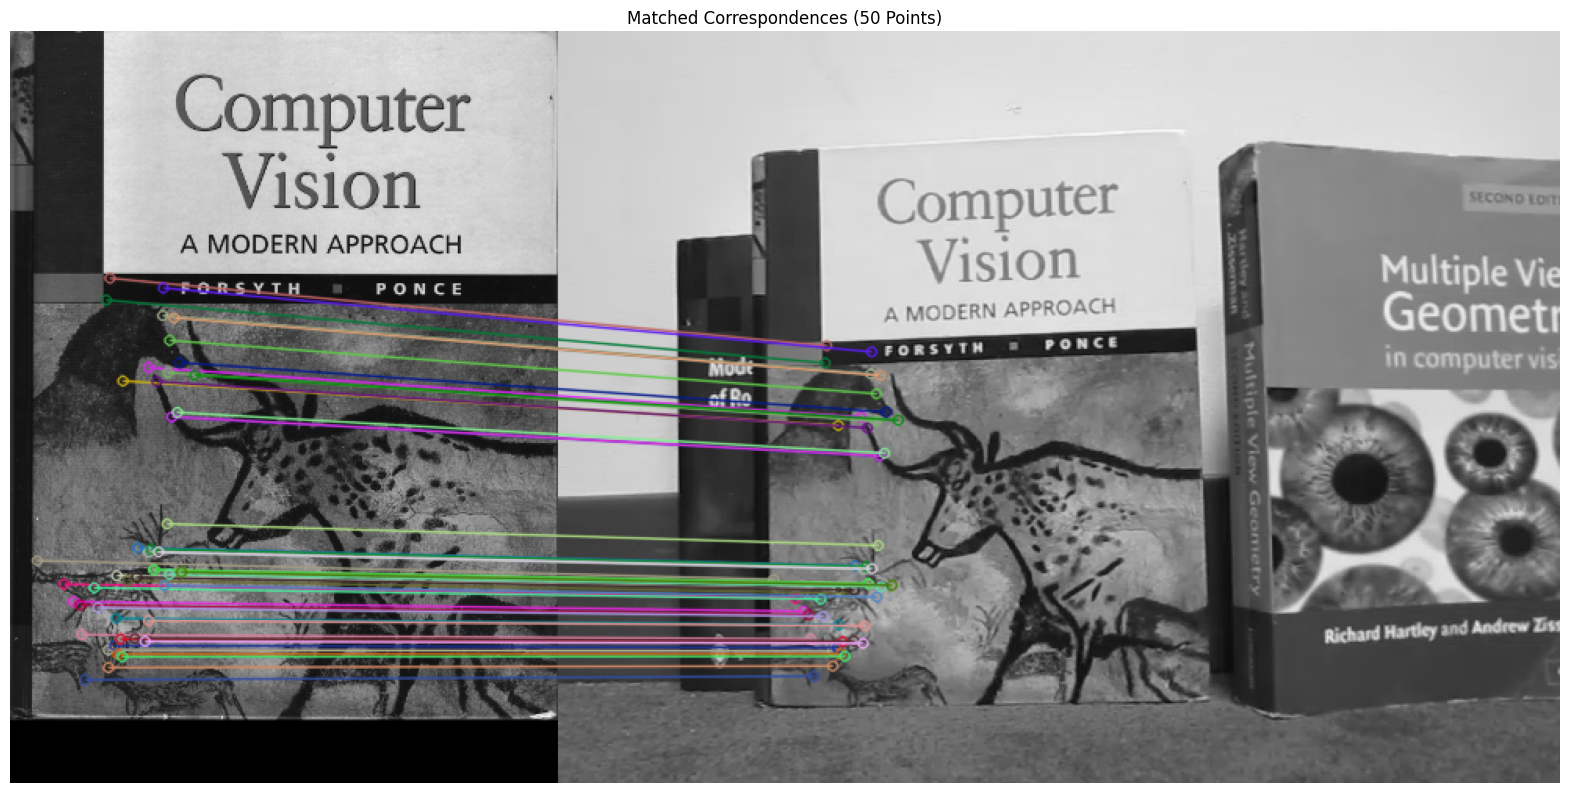

In [239]:
# Initialize SIFT detector
sift = cv2.SIFT_create()
# Detect keypoints and compute descriptors
kp_book, des_book = sift.detectAndCompute(gray_book, None)
kp_video, des_video = sift.detectAndCompute(gray_video, None)
# Brute-Force Matcher with KNN (k=2)
bf = cv2.BFMatcher()
#finds the two best matches for each descriptor (for applying Lowe's ratio test).
matches = bf.knnMatch(des_book, des_video, k=2)
# Apply ratio test (Lowe's ratio = 0.5)
good_matches = []
for m, n in matches:
    ratio = m.distance / n.distance  # Explicit ratio calculation
    if ratio < 0.5:  # Compare against threshold
        good_matches.append(m)
# Select top 50 matches
selected_matches = good_matches[:50]
# Draw matches
matched_img = cv2.drawMatches(gray_book, kp_book,gray_video, kp_video,selected_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
# Display the result
plt.figure(figsize=(20, 10))
plt.imshow(matched_img)
plt.axis('off')
plt.title('Matched Correspondences (50 Points)')
plt.show()

Lowe's Ratio Test is a method introduced by David Lowe in his SIFT paper to filter ambiguous feature matches. It works by comparing the ratio of the distances between the best and second-best matches in the feature descriptor space. A lower ratio number introduces a stricter Filter

1.2) Compute the Homography Parameters  
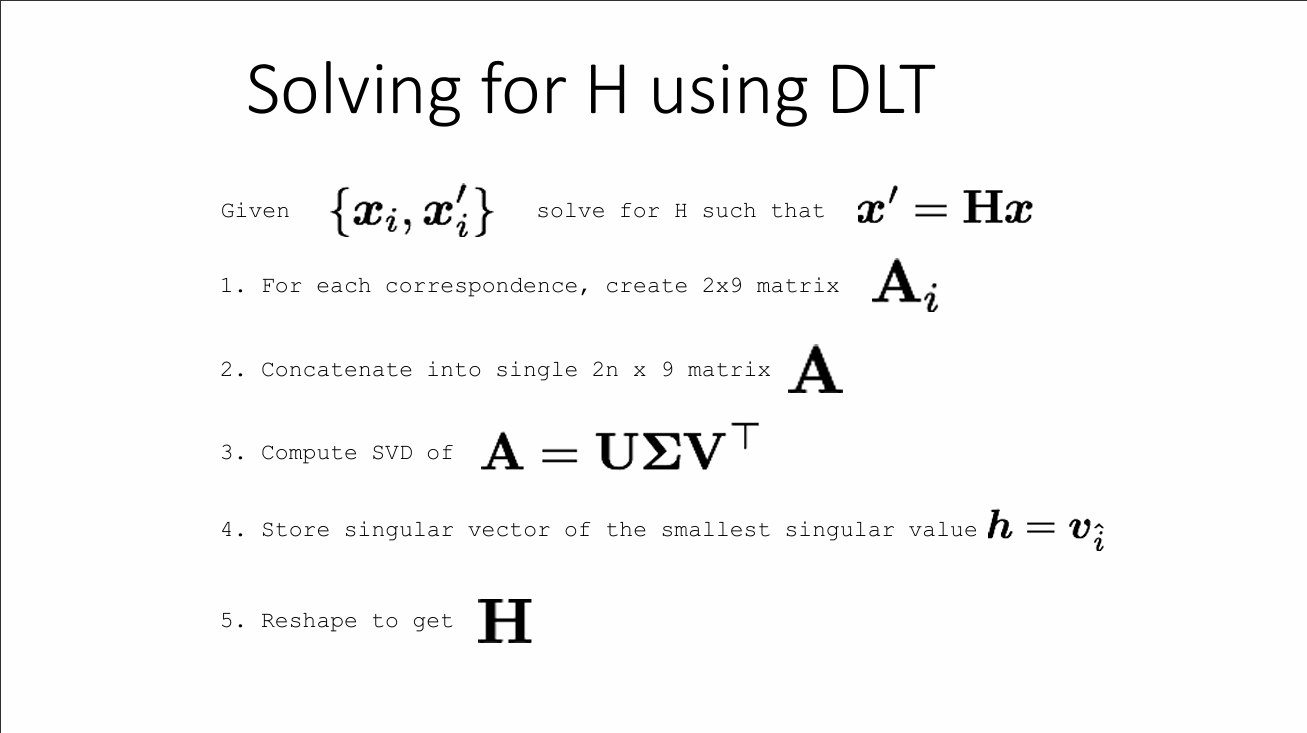

In [240]:
import numpy as np

def compute_homography(src_pts, dst_pts):
    # Ensure there are at least 4 point correspondences
    assert len(src_pts) >= 4, "At least 4 correspondences src points are required."
    assert len(dst_pts) >= 4, "At least 4 correspondences dst points are required."
    n = src_pts.shape[0]
    # Step 1: Create 2x9 matrix for each correspondence
    A = []
    for i in range(n):
        x, y = src_pts[i]
        xp, yp = dst_pts[i]
        # Construct the matrix for the current point correspondence
        row1 = [x, y, 1, 0, 0, 0, -x * xp, -y * xp, -xp]
        row2 = [0, 0, 0, x, y, 1, -x * yp, -y * yp, -yp]
        A.append(row1)
        A.append(row2)
    # Step 2: Concatenate into a single 2n x 9 matrix
    A = np.array(A)
    # Step 3: Compute the SVD of A
    _, _, Vt = np.linalg.svd(A)
    # Step 4: The singular vector corresponding to the smallest singular value is the last row of Vt
    h = Vt[-1]
    # Step 5: Reshape to get the 3x3 homography matrix
    H = h.reshape(3, 3)
    # Normalize the matrix to ensure H[2, 2] = 1
    H /= H[2, 2]
    return H


Computes the homography matrix H using Direct Linear Transform (DLT).
    Args:
        src_pts: (n, 2) numpy array of source image points.
        dst_pts: (n, 2) numpy array of destination image points.
    Returns:
        H: (3, 3) homography matrix.

In [241]:
def verify_homography(H, src_pts):
    """
    Projects source points using H and visualizes alignment with destination points.
    """
    # Project source points to destination
    projected_pts = []
    for pt in src_pts:
        p_homo = np.array([pt[0], pt[1], 1.0])
        p_proj = H @ p_homo  #p'=H.p
        p_proj /= p_proj[2]  # Normalize [x'/w y'/w]
        projected_pts.append(p_proj[:2])
    projected_pts = np.array(projected_pts)
    return projected_pts

In [242]:
# Compute homography
# Extract coordinates of matched keypoints
src_pts = np.float32([kp_book[m.queryIdx].pt for m in selected_matches]).reshape(-1, 2)
dst_pts = np.float32([kp_video[m.trainIdx].pt for m in selected_matches]).reshape(-1, 2)
H = compute_homography(src_pts, dst_pts)
print("Homography matrix using DLT with svd: \n",H)
# Verify alignment
projected_pts=verify_homography(H, src_pts)

Homography matrix using DLT with svd: 
 [[ 7.70758396e-01  6.30419200e-03  1.18679370e+02]
 [-6.37385353e-02  7.82547259e-01  7.76255784e+01]
 [-1.21908833e-04 -6.41583864e-05  1.00000000e+00]]


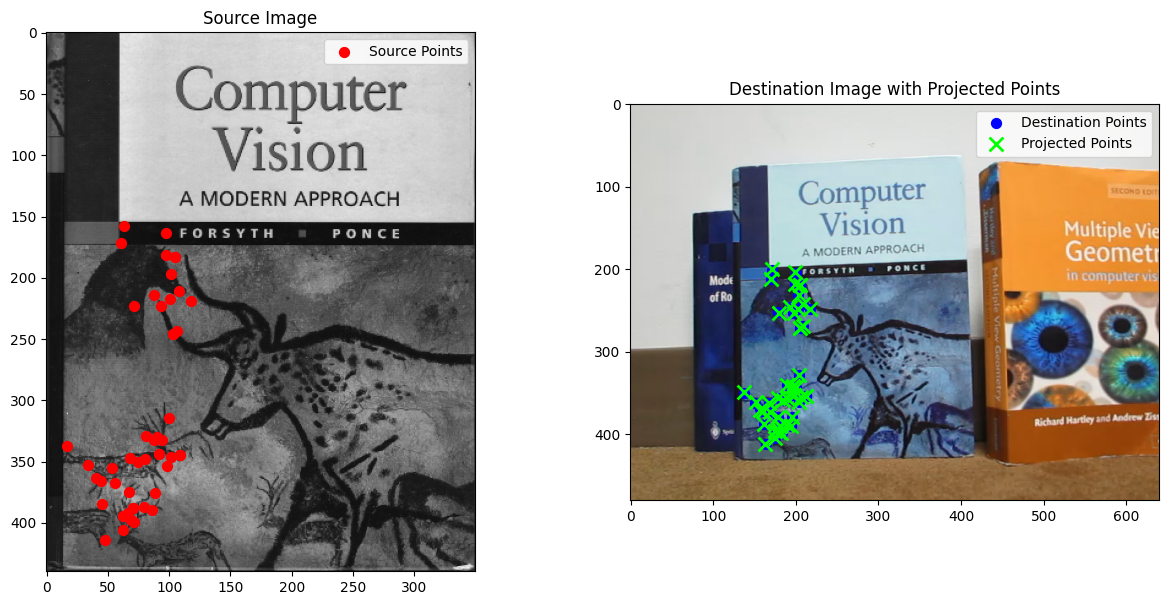

Reprojection Error (Avg): 0.35 pixels


In [243]:
# Plot results
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(img_book)
plt.scatter(src_pts[:, 0], src_pts[:, 1], c='red', s=50, label='Source Points')
plt.title('Source Image')
plt.legend()
plt.subplot(1, 2, 2)
plt.imshow(frame_video)
plt.scatter(dst_pts[:, 0], dst_pts[:, 1], c='blue', s=50, label='Destination Points')
plt.scatter(projected_pts[:, 0], projected_pts[:, 1], c='lime', marker='x', s=100, linewidth=2, label='Projected Points')
plt.title('Destination Image with Projected Points')
plt.legend()
plt.show()
# Compute reprojection error
error = np.mean(np.linalg.norm(projected_pts - dst_pts, axis=1))
print(f"Reprojection Error (Avg): {error:.2f} pixels")

1.3) Calculate Book Coordinates

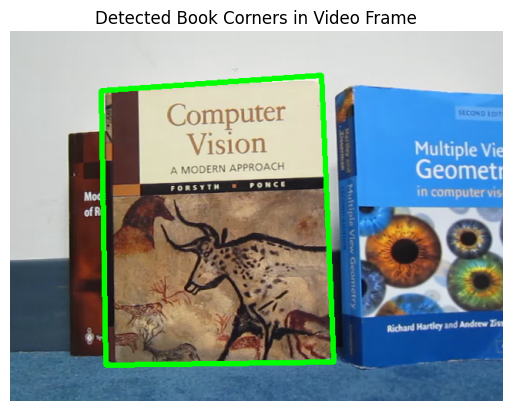

In [244]:
# Step 1: Define book corners
height, width = img_book.shape[:2]  #get height and width from the img given
corners_book = np.float32([[0, 0], [width-1, 0], [width-1, height-1], [0, height-1]]) #get the 4 corners in the img
# Step 2: Project corners to video frame
corners_book_reshaped = corners_book.reshape(-1, 1, 2)
'''Reshapes corners_book into shape (N, 1, 2), which is the required input format for cv2.perspectiveTransform.'''
corners_video = cv2.perspectiveTransform(corners_book_reshaped, H)
'''Applies the homography matrix H to each point in corners_book_reshaped.  p'=H.p '''
corners_video = corners_video.reshape(-1, 2).astype(int)
'''Reshapes the transformed points back to a standard 2D format: shape (N, 2)
Converts the coordinates to integers (since pixel locations are integers)'''
# Step 3: Visualize
frame_with_corners = frame_video_rgb.copy()
cv2.polylines(frame_with_corners, [corners_video], isClosed=True, color=(0, 255, 0), thickness=5) #plot polygon on the video frame
plt.imshow(frame_with_corners)
plt.title('Detected Book Corners in Video Frame')
plt.axis('off')
plt.show()

1.4) Crop AR Video Frames

In [245]:
def get_crop_box(frame_w, frame_h, target_ar):
    frame_ar = frame_w / frame_h
    if target_ar > frame_ar:
        # Width-limited crop => the full width is used, height shrinks
        crop_w = frame_w
        crop_h = int(crop_w / target_ar)
    else:
        # Height-limited crop => the full height is used, width shrinks
        crop_h = frame_h
        crop_w = int(crop_h * target_ar)

    # Center the crop
    x = (frame_w - crop_w) // 2
    y = (frame_h - crop_h) // 2
    return x, y, crop_w, crop_h
def remove_black_edges(img, threshold=10):
    """Remove top and bottom black edges from an RGB image."""
    # Create a mask for non-black pixels
    mask = np.any(img > threshold, axis=2)
    
    # Find rows that have non-black pixels
    rows = np.any(mask, axis=1)
    
    # Find top and bottom bounds
    top = np.argmax(rows)
    bottom = len(rows) - np.argmax(rows[::-1])
    
    # Crop the image vertically
    cropped_img = img[top:bottom, :]
    return cropped_img

In [246]:
img_book = cv2.cvtColor(cv2.imread('cv_cover.jpg'), cv2.COLOR_BGR2RGB)
height_book, width_book = img_book.shape[:2] 
target_aspect_ratio = width_book / height_book
##source video (ar) that wil be warped on book
ar_cap = cv2.VideoCapture('ar_source.mov')
ar_frame = None
ar_frames=[]
while(1):
    ret, ar_frame = ar_cap.read()
    if not ret:
        break
    ar_frame=remove_black_edges(ar_frame)
    ar_frame_rgb = cv2.cvtColor(ar_frame, cv2.COLOR_BGR2RGB)
    ar_height, ar_width = ar_frame_rgb.shape[:2]
    crop_x, crop_y, crop_w, crop_h = get_crop_box(
    ar_width, ar_height, target_aspect_ratio)
    ar_frame_with_rect = ar_frame_rgb.copy()
    cv2.rectangle(ar_frame_with_rect,(crop_x, crop_y),(crop_x + crop_w, crop_y + crop_h),(255, 255, 0),5)
    cropped_ar = ar_frame_rgb[crop_y : crop_y + crop_h,crop_x : crop_x + crop_w]
    cropped_ar_resized = cv2.resize(cropped_ar, (width_book, height_book))
    ar_frames.append(cropped_ar_resized)
ar_cap.release()

1.5) Overlay the First Frame of the Two Videos

In [247]:
desired_frame = 30*12
Frame=ar_frames[desired_frame]
ar_height, ar_width = Frame.shape[:2]
# Define the perspective transformation
warped_ar_image = cv2.warpPerspective(Frame, H, (frame_video.shape[1], frame_video.shape[0]))
# Step 6: Create a mask for the AR image to blend it correctly into the video frame
# Create an all-black mask of the same size as the video frame
mask = np.zeros_like(frame_video, dtype=np.uint8)
# Create a polygon mask based on the corners of the AR image (the warped corners)
cv2.fillPoly(mask, [corners_video], (255, 255, 255))
# Step 7: Blend the AR image into the video frame
# We use bitwise operations to blend the warped AR image with the video frame
frame_with_ar = frame_video.copy()
warped_ar_image_masked = cv2.bitwise_and(warped_ar_image, mask)
frame_with_ar_masked = cv2.bitwise_and(frame_with_ar, cv2.bitwise_not(mask))
# Combine both to get the final image with the AR content overlaid
frame_with_ar_final = cv2.add(frame_with_ar_masked, warped_ar_image_masked)


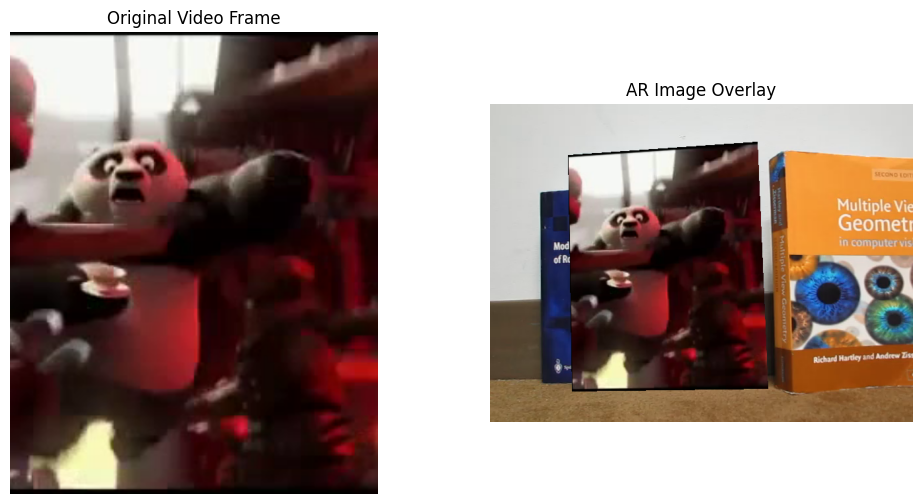

In [248]:
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
# Plot the first image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first image
plt.imshow(Frame)
plt.title('Original Video Frame')
plt.axis('off')  # Turn off axis
# Plot the second image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second image
plt.imshow(frame_with_ar_final)
plt.title('AR Image Overlay')
plt.axis('off')  # Turn off axis
# Show the plot
plt.show()

In [249]:
img_book = cv2.imread("cv_cover.jpg")  
img_book = cv2.cvtColor(img_book, cv2.COLOR_BGR2RGB)
gray_book = cv2.cvtColor(img_book, cv2.COLOR_RGB2GRAY)
corners_book = np.float32([[0, 0], [width-1, 0], [width-1, height-1], [0, height-1]]) #get the 4 corners in the img
corners_book_reshaped = corners_book.reshape(-1, 1, 2)
book_cap = cv2.VideoCapture('book.mov')
book_frame = None
book_frames=[]
output_frames=[]
while(1):
    ret, book_frame = book_cap.read()
    if not ret:
        break
    book_frames.append(book_frame)
book_cap.release()


1.6) Creating AR Application

In [250]:

for i in range(min(len(book_frames),len(ar_frames))):
    frame_video = book_frames[i]  # BGR
    gray_video = cv2.cvtColor(frame_video, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    # Detect keypoints and compute descriptors
    kp_book, des_book = sift.detectAndCompute(gray_book, None)
    kp_video, des_video = sift.detectAndCompute(gray_video, None)
    # Brute-Force Matcher with KNN (k=2)
    bf = cv2.BFMatcher()
    #finds the two best matches for each descriptor (for applying Lowe's ratio test).
    matches = bf.knnMatch(des_book, des_video, k=2)
    # Apply ratio test (Lowe's ratio = 0.5)
    good_matches = []
    for m, n in matches:
        ratio = m.distance / n.distance  # Explicit ratio calculation
        if ratio < 0.3:  # Compare against threshold
            good_matches.append(m)
    # Select top 50 matches
    selected_matches = good_matches[:50]
    src_pts = np.float32([kp_book[m.queryIdx].pt for m in selected_matches]).reshape(-1, 2)
    dst_pts = np.float32([kp_video[m.trainIdx].pt for m in selected_matches]).reshape(-1, 2)
    H = compute_homography(src_pts, dst_pts)

    
    corners_video = cv2.perspectiveTransform(corners_book_reshaped, H)
    corners_video = corners_video.reshape(-1, 2).astype(int)

    
    Frame = ar_frames[i]  # RGB AR frame
    ar_height, ar_width = Frame.shape[:2]
    warped_ar_image = cv2.warpPerspective(Frame, H, (frame_video.shape[1], frame_video.shape[0]))
    mask = np.zeros_like(frame_video, dtype=np.uint8)
    cv2.fillPoly(mask, [corners_video], (255, 255, 255))
    frame_with_ar = frame_video.copy()
    warped_ar_image_bgr = cv2.cvtColor(warped_ar_image, cv2.COLOR_RGB2BGR)
    warped_ar_image_masked = cv2.bitwise_and(warped_ar_image_bgr, mask)
    frame_with_ar_masked = cv2.bitwise_and(frame_with_ar, cv2.bitwise_not(mask))
    frame_with_ar_final = cv2.add(frame_with_ar_masked, warped_ar_image_masked)
    output_frames.append(frame_with_ar_final)


    

In [ ]:
output_path = 'output_ar_video.mp4'
fps = 25  # Match this with the AR or book video FPS
# Get dimensions from the first frame
height, width = output_frames[0].shape[:2]
# Choose codec
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' works well for .mp4 files
# Initialize video writer
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
# Write all frames to the video
for frame in output_frames:
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert from RGB to BGR
    out.write(frame_bgr)
out.release()
print(f"✅ Video saved to {output_path}")
########

✅ Video saved to output_ar_video.mp4
